In [ ]:
# Load data.csv from Moodle
# Lab03 solution from anibals

# Exec 1

## Exec 1.a)
 State Estimation (True vs Estimation)

<ipython-input-15-890955f0a627>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('data.txt', delim_whitespace=True, header=None)


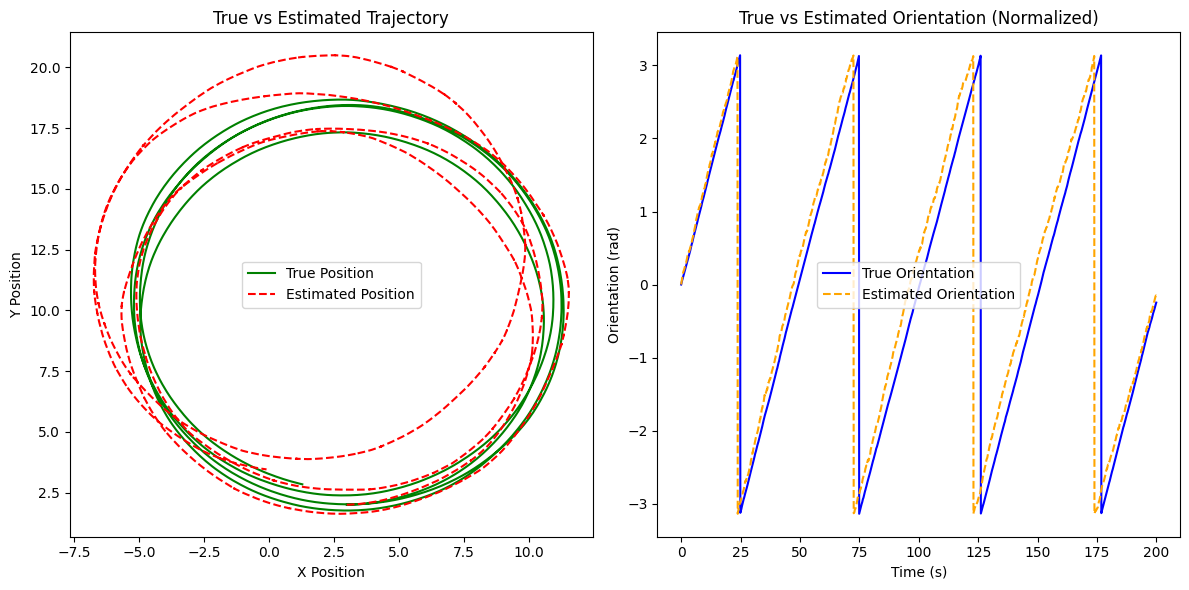

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Constants for noise
sigma_v = 0.5  # Standard deviation for linear velocity noise
sigma_omega = 0.05  # Standard deviation for angular velocity noise

# Load the data
data = pd.read_csv('data.txt', delim_whitespace=True, header=None)
data.columns = ['t', 'x', 'y', 'theta', 'v', 'omega', 'r1', 'psi1', 'r2', 'psi2']

# Extract initial state
x_est = [data.iloc[0]['x']]
y_est = [data.iloc[0]['y']]
theta_est = [data.iloc[0]['theta']]

# Time step
dt = data['t'].diff().fillna(0).values

# Dead reckoning loop
for i in range(1, len(data)):
    # Get previous estimates
    x_prev, y_prev, theta_prev = x_est[-1], y_est[-1], theta_est[-1]

    # Get noisy measurements
    v = data.iloc[i]['v'] + np.random.normal(0, sigma_v)
    omega = data.iloc[i]['omega'] + np.random.normal(0, sigma_omega)

    # Compute new estimates
    x_new = x_prev + v * np.cos(theta_prev) * dt[i]
    y_new = y_prev + v * np.sin(theta_prev) * dt[i]
    theta_new = theta_prev + omega * dt[i]

    # Append new estimates
    x_est.append(x_new)
    y_est.append(y_new)
    theta_est.append(theta_new)

# Convert to numpy arrays for easier manipulation
x_est = np.array(x_est)
y_est = np.array(y_est)
theta_est = np.array(theta_est)

# Extract true values for comparison
x_true = data['x'].values
y_true = data['y'].values
theta_true = data['theta'].values

# Function to normalize theta within [-pi, pi]
def normalize_angle(theta):
    return (theta + np.pi) % (2 * np.pi) - np.pi

# Normalize the estimated theta values
theta_est_normalized = normalize_angle(theta_est)

# Normalize the true theta values for consistency (though it should already be normalized)
theta_true_normalized = normalize_angle(theta_true)

# Plotting
plt.figure(figsize=(12, 6))

# True vs Estimated positions
plt.subplot(1, 2, 1)
plt.plot(x_true, y_true, label='True Position', color='green')
plt.plot(x_est, y_est, label='Estimated Position', linestyle='--', color='red')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('True vs Estimated Trajectory')
plt.legend()

# Orientation comparison with normalization
plt.subplot(1, 2, 2)
plt.plot(data['t'], theta_true_normalized, label='True Orientation', color='blue')
plt.plot(data['t'], theta_est_normalized, label='Estimated Orientation', linestyle='--', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Orientation (rad)')
plt.title('True vs Estimated Orientation (Normalized)')
plt.legend()

plt.tight_layout()
plt.show()

## Exec 1.b)

Extended Kalman Filter (EKF)

# New Section

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Constants for noise
sigma_v = 0.5  # Standard deviation for linear velocity noise
sigma_omega = 0.05  # Standard deviation for angular velocity noise
sigma_r = 0.5  # Standard deviation for range measurement noise
sigma_psi = 0.1  # Standard deviation for bearing measurement noise

# Process noise covariance
Q = np.diag([sigma_v**2, sigma_omega**2])

# Measurement noise covariance
R = np.diag([sigma_r**2, sigma_psi**2, sigma_r**2, sigma_psi**2]) * 10

# Load the data
data = pd.read_csv('data.txt', delim_whitespace=True, header=None)
data.columns = ['t', 'x', 'y', 'theta', 'v', 'omega', 'r1', 'psi1', 'r2', 'psi2']

# Extract beacon positions
beacon_positions = np.array([[0, 0], [10, 0]])

# Initial state and covariance
x_est = np.array([[data.iloc[0]['x']], [data.iloc[0]['y']], [data.iloc[0]['theta']]])
P = np.eye(3)  # Initial covariance matrix

# Time step
dt = data['t'].diff().fillna(0).values

# Store estimates for plotting
x_estimates = [x_est.flatten()]

# Create a folder to save the frames
output_folder = "ekf_frames"
os.makedirs(output_folder, exist_ok=True)

# EKF implementation
for i in range(1, len(data)):
    # Frame
    print(f"Frame {i}")

    # Get noisy control inputs
    v = data.iloc[i]['v'] + np.random.normal(0, sigma_v)
    omega = data.iloc[i]['omega'] + np.random.normal(0, sigma_omega)

    # ---- Prediction Step ----
    theta = x_est[2, 0]
    x_pred = x_est + np.array([
        [v * np.cos(theta) * dt[i]],
        [v * np.sin(theta) * dt[i]],
        [omega * dt[i]]
    ])
    x_pred[2, 0] = (x_pred[2, 0] + np.pi) % (2 * np.pi) - np.pi

    F = np.array([
        [1, 0, -v * np.sin(theta) * dt[i]],
        [0, 1, v * np.cos(theta) * dt[i]],
        [0, 0, 1]
    ])

    B = np.array([
        [np.cos(theta) * dt[i], 0],
        [np.sin(theta) * dt[i], 0],
        [0, dt[i]]
    ])

    P_pred = F @ P @ F.T + B @ Q @ B.T

    # ---- Update Step ----
    z_pred = []
    H = []
    for j, (bx, by) in enumerate(beacon_positions):
        dx = bx - x_pred[0, 0]
        dy = by - x_pred[1, 0]
        r_pred = np.sqrt(dx**2 + dy**2)
        psi_pred = np.arctan2(dy, dx) - x_pred[2, 0]
        psi_pred = (psi_pred + np.pi) % (2 * np.pi) - np.pi

        z_pred.extend([r_pred, psi_pred])
        H_j = np.array([
            [-dx / r_pred, -dy / r_pred, 0],
            [dy / (r_pred**2), -dx / (r_pred**2), -1]
        ])
        H.append(H_j)

    H = np.vstack(H)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    z = np.array([
        data.iloc[i]['r1'], data.iloc[i]['psi1'],
        data.iloc[i]['r2'], data.iloc[i]['psi2']
    ])

    z_pred = np.array(z_pred)
    z_diff = z - z_pred
    z_diff[1] = (z_diff[1] + np.pi) % (2 * np.pi) - np.pi
    z_diff[3] = (z_diff[3] + np.pi) % (2 * np.pi) - np.pi

    x_est = x_pred + K @ z_diff.reshape(-1, 1)
    P = (np.eye(len(P)) - K @ H) @ P_pred

    x_estimates.append(x_est.flatten())

    # ---- Generate Plot for Current Step ----
    plt.figure(figsize=(12, 6))

    # Trajectory
    plt.subplot(1, 2, 1)
    plt.plot(data['x'][:i+1], data['y'][:i+1], label='True Position', color='green')
    plt.plot([x[0] for x in x_estimates], [x[1] for x in x_estimates], label='Estimated Position', linestyle='--', color='red')
    plt.scatter(beacon_positions[:, 0], beacon_positions[:, 1], marker='*', color='blue', label='Beacons')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Step {i}: True vs Estimated Trajectory')
    plt.legend()

    # Orientation
    plt.subplot(1, 2, 2)
    plt.plot(data['t'][:i+1], data['theta'][:i+1], label='True Orientation', color='blue')
    plt.plot(data['t'][:i+1], [x[2] for x in x_estimates], label='Estimated Orientation', linestyle='--', color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Orientation (rad)')
    plt.title(f'Step {i}: True vs Estimated Orientation')
    plt.legend()

    plt.tight_layout()

    # Save the current plot as an image
    plt.savefig(f'{output_folder}/frame_{i:03d}.png')
    plt.close()

print(f"Frames saved in folder: {output_folder}")

<ipython-input-16-0b9ff9475465>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('data.txt', delim_whitespace=True, header=None)


Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Frame 52
Frame 53
Frame 54
Frame 55
Frame 56
Frame 57
Frame 58
Frame 59
Frame 60
Frame 61
Frame 62
Frame 63
Frame 64
Frame 65
Frame 66
Frame 67
Frame 68
Frame 69
Frame 70
Frame 71
Frame 72
Frame 73
Frame 74
Frame 75
Frame 76
Frame 77
Frame 78
Frame 79
Frame 80
Frame 81
Frame 82
Frame 83
Frame 84
Frame 85
Frame 86
Frame 87
Frame 88
Frame 89
Frame 90
Frame 91
Frame 92
Frame 93
Frame 94
Frame 95
Frame 96
Frame 97
Frame 98
Frame 99
Frame 100
Frame 101
Frame 102
Frame 103
Frame 104
Frame 105
Frame 106
Frame 107
Frame 108
Frame 109
Frame 110
Frame 11

In [ ]:
from pathlib import Path
import imageio
import glob
import re

def natural_sort_key(s):
    """
    Sort strings that contain numbers in natural order
    For example: ["img1.png", "img2.png", "img10.png"] instead of ["img1.png", "img10.png", "img2.png"]
    """
    s = str(s)
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

# Define the output folder
output_folder = Path("ekf_frames")

# Create video using your method
images = list(output_folder.glob('*.png'))  # Use Path.glob
images.sort(key=natural_sort_key)
print(f"Found {len(images)} images")

# Read frames
frames = [imageio.v2.imread(str(img)) for img in images]

# Create video directory
video_dir = output_folder.parent / 'videos'
video_dir.mkdir(parents=True, exist_ok=True)

# Save video
video_path = video_dir / 'ekf.mp4'
imageio.mimwrite(str(video_path), frames, fps=2, macro_block_size=1)
print(f"Video created successfully at {video_path}!")

Found 1999 images
Video created successfully at videos/ekf.mp4!


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/videos/ekf.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1500 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

## Exec 1.c)

Unscented Kalman Filter (UKF)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data
data = pd.read_csv('data.txt', sep='\s+', header=None)  # Load the data from a space-separated text file
data.columns = ['t', 'x', 'y', 'theta', 'v', 'omega', 'r1', 'psi1', 'r2', 'psi2']  # Define column names

# Constants and parameters for the Unscented Kalman Filter
n = 3  # State dimensionality (x, y, theta)
alpha = 1e-3  # Scaling parameter to control the spread of sigma points
beta = 2  # Parameter to incorporate prior knowledge about the distribution (optimal for Gaussian)
kappa = 0  # Secondary scaling parameter
lambda_ = alpha**2 * (n + kappa) - n  # Composite scaling parameter for sigma points
gamma = np.sqrt(n + lambda_)  # Scaling factor for generating sigma points

# Beacon positions (used for measurement)
beacon_positions = np.array([[0, 0], [10, 0]])  # (x, y) positions of two beacons

# Weights for sigma points
W_m0 = lambda_ / (n + lambda_)  # Weight for the central sigma point (mean calculation)
W_mi = 1 / (2 * (n + lambda_))  # Weights for remaining sigma points (mean calculation)
W_c0 = W_m0 + (1 - alpha**2 + beta)  # Weight for the central sigma point (covariance calculation)
W_ci = W_mi  # Weights for remaining sigma points (covariance calculation)

# Initial state estimate (from the first row of data)
x_est = np.array([data.iloc[0]['x'], data.iloc[0]['y'], data.iloc[0]['theta']])  # Initial position and orientation
P = np.eye(n) # Initial state covariance matrix (small uncertainty)
Q = np.diag([1e-3, 1e-3, 1e-3])  # Process noise covariance (model uncertainty)
R = np.diag([0.5, 0.1, 0.5, 0.1]) * 10  # Measurement noise covariance (sensor uncertainty)

# Time step between consecutive data points
dt = data['t'].diff().fillna(0).values  # Calculate time differences and fill the first row with 0

# Store state estimates for plotting
x_estimates = [x_est.copy()]

# Create a folder to save the frames
output_folder = "ukf_frames"
os.makedirs(output_folder, exist_ok=True)

# Unscented Kalman Filter Algorithm
for i in range(1, len(data)):
    # Frame
    print(f"Frame {i}")

    # ---- Prediction Step ----
    # Generate sigma points using the current state and covariance
    sqrt_P = np.linalg.cholesky(P)  # Cholesky decomposition of P to compute sigma points
    sigma_points = np.vstack([
        x_est,  # Central sigma point
        x_est + gamma * sqrt_P.T,  # Positive sigma points
        x_est - gamma * sqrt_P.T   # Negative sigma points
    ])

    # Propagate sigma points through the process model
    sigma_points_pred = []
    for sp in sigma_points:
        theta = sp[2]  # Extract the orientation angle
        v = data.iloc[i]['v']  # Linear velocity from data
        omega = data.iloc[i]['omega']  # Angular velocity from data
        sp_pred = sp + np.array([v * np.cos(theta) * dt[i],  # Update x
                                 v * np.sin(theta) * dt[i],  # Update y
                                 omega * dt[i]])  # Update theta
        sp_pred[2] = (sp_pred[2] + np.pi) % (2 * np.pi) - np.pi  # Normalize angle to [-pi, pi]
        sigma_points_pred.append(sp_pred)
    sigma_points_pred = np.array(sigma_points_pred)  # Convert to numpy array

    # Predicted state mean (weighted sum of sigma points)
    x_pred = W_m0 * sigma_points_pred[0] + np.sum(W_mi * sigma_points_pred[1:], axis=0)

    # Predicted state covariance (weighted outer products of deviations)
    sig_diff = sigma_points_pred[0] - x_pred  # Deviation from the predicted mean
    P_pred = W_c0 * np.dot(sig_diff.reshape(-1, 1), sig_diff.reshape(1, -1))  # First term of covariance

    for j in range(1, 2 * n + 1):
        sig_diff = sigma_points_pred[j] - x_pred  # Deviation from the predicted mean
        P_pred += W_ci * np.dot(sig_diff.reshape(-1, 1), sig_diff.reshape(1, -1))  # Add remaining terms

    P_pred += Q  # Add process noise covariance

    # ---- Measurement Prediction ----
    z_pred_points = []  # Predicted measurements from each sigma point
    for sp in sigma_points_pred:
        z_sp = []
        for bx, by in beacon_positions:
            dx = bx - sp[0]  # Difference in x
            dy = by - sp[1]  # Difference in y
            r = np.sqrt(dx**2 + dy**2)  # Distance to beacon
            psi = np.arctan2(dy, dx) - sp[2]  # Bearing to beacon relative to orientation
            psi = (psi + np.pi) % (2 * np.pi) - np.pi  # Normalize angle
            z_sp.extend([r, psi])  # Add distance and bearing to predicted measurement
        z_pred_points.append(z_sp)

    z_pred_points = np.array(z_pred_points)  # Convert to numpy array
    z_pred = W_m0 * z_pred_points[0] + np.sum(W_mi * z_pred_points[1:], axis=0)  # Predicted measurement mean

    # Predicted measurement covariance
    sig_diff_z = z_pred_points[0] - z_pred  # Measurement deviation
    P_z = W_c0 * np.dot(sig_diff_z.reshape(-1, 1), sig_diff_z.reshape(1, -1))  # First term of measurement covariance

    for j in range(1, 2 * n + 1):
        sig_diff_z = z_pred_points[j] - z_pred  # Measurement deviation
        P_z += W_ci * np.dot(sig_diff_z.reshape(-1, 1), sig_diff_z.reshape(1, -1))  # Add remaining terms

    P_z += R  # Add measurement noise covariance

    # ---- Cross Covariance ----
    sig_diff_xz = sigma_points_pred[0] - x_pred  # State deviation
    sig_diff_zx = z_pred_points[0] - z_pred  # Measurement deviation
    P_xz = W_c0 * np.dot(sig_diff_xz.reshape(-1, 1), sig_diff_zx.reshape(1, -1))  # First term of cross-covariance

    for j in range(1, 2 * n + 1):
        sig_diff_xz = sigma_points_pred[j] - x_pred  # State deviation
        sig_diff_zx = z_pred_points[j] - z_pred  # Measurement deviation
        P_xz += W_ci * np.dot(sig_diff_xz.reshape(-1, 1), sig_diff_zx.reshape(1, -1))  # Add remaining terms

    # ---- Update Step ----
    K = np.dot(P_xz, np.linalg.inv(P_z))  # Kalman gain
    z = np.array([data.iloc[i]['r1'], data.iloc[i]['psi1'], data.iloc[i]['r2'], data.iloc[i]['psi2']])  # Current measurement
    z_diff = z - z_pred  # Measurement residual
    z_diff[1] = (z_diff[1] + np.pi) % (2 * np.pi) - np.pi  # Normalize angle residual for psi1
    z_diff[3] = (z_diff[3] + np.pi) % (2 * np.pi) - np.pi  # Normalize angle residual for psi2

    x_est = x_pred + np.dot(K, z_diff)  # Updated state estimate
    P = P_pred - np.dot(np.dot(K, P_z), K.T)  # Updated state covariance

    # Store the updated state estimate for plotting
    x_estimates.append(x_est.copy())

    # ---- Generate Plot for Current Step ----
    plt.figure(figsize=(12, 6))

    # Trajectory plot
    plt.subplot(1, 2, 1)
    plt.plot(data['x'][:i+1], data['y'][:i+1], label='True Position', color='green')  # True trajectory
    plt.plot([x[0] for x in x_estimates], [x[1] for x in x_estimates], label='Estimated Position', linestyle='--', color='red')  # Estimated trajectory
    plt.scatter(beacon_positions[:, 0], beacon_positions[:, 1], marker='*', color='blue', label='Beacons')  # Beacons
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Step {i}: True vs Estimated Trajectory')
    plt.legend()

    # Orientation plot
    plt.subplot(1, 2, 2)
    plt.plot(data['t'][:i+1], data['theta'][:i+1], label='True Orientation', color='blue')  # True orientation
    plt.plot(data['t'][:i+1], [x[2] for x in x_estimates], label='Estimated Orientation', linestyle='--', color='orange')  # Estimated orientation
    plt.xlabel('Time (s)')
    plt.ylabel('Orientation (rad)')
    plt.title(f'Step {i}: True vs Estimated Orientation')
    plt.legend()

    plt.tight_layout()

    # Save the current plot as an image
    plt.savefig(f'{output_folder}/frame_{i:03d}.png')
    plt.close()  # Close the plot to free memory

Frame 1
Frame 2
Frame 3
Frame 4
Frame 5
Frame 6
Frame 7
Frame 8
Frame 9
Frame 10
Frame 11
Frame 12
Frame 13
Frame 14
Frame 15
Frame 16
Frame 17
Frame 18
Frame 19
Frame 20
Frame 21
Frame 22
Frame 23
Frame 24
Frame 25
Frame 26
Frame 27
Frame 28
Frame 29
Frame 30
Frame 31
Frame 32
Frame 33
Frame 34
Frame 35
Frame 36
Frame 37
Frame 38
Frame 39
Frame 40
Frame 41
Frame 42
Frame 43
Frame 44
Frame 45
Frame 46
Frame 47
Frame 48
Frame 49
Frame 50
Frame 51
Frame 52
Frame 53
Frame 54
Frame 55
Frame 56
Frame 57
Frame 58
Frame 59
Frame 60
Frame 61
Frame 62
Frame 63
Frame 64
Frame 65
Frame 66
Frame 67
Frame 68
Frame 69
Frame 70
Frame 71
Frame 72
Frame 73
Frame 74
Frame 75
Frame 76
Frame 77
Frame 78
Frame 79
Frame 80
Frame 81
Frame 82
Frame 83
Frame 84
Frame 85
Frame 86
Frame 87
Frame 88
Frame 89
Frame 90
Frame 91
Frame 92
Frame 93
Frame 94
Frame 95
Frame 96
Frame 97
Frame 98
Frame 99
Frame 100
Frame 101
Frame 102
Frame 103
Frame 104
Frame 105
Frame 106
Frame 107
Frame 108
Frame 109
Frame 110
Frame 11

In [1]:
from pathlib import Path
import imageio
import glob
import re

def natural_sort_key(s):
    """
    Sort strings that contain numbers in natural order
    For example: ["img1.png", "img2.png", "img10.png"] instead of ["img1.png", "img10.png", "img2.png"]
    """
    s = str(s)
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split('([0-9]+)', s)]

# Define the output folder
output_folder = Path("ukf_frames")

# Create video using your method
images = list(output_folder.glob('*.png'))  # Use Path.glob
images.sort(key=natural_sort_key)
print(f"Found {len(images)} images")

# Read frames
frames = [imageio.v2.imread(str(img)) for img in images]

# Create video directory
video_dir = output_folder.parent / 'videos'
video_dir.mkdir(parents=True, exist_ok=True)

# Save video
video_path = video_dir / 'ukf.mp4'
imageio.mimwrite(str(video_path), frames, fps=2, macro_block_size=1)
print(f"Video created successfully at {video_path}!")

Found 1658 images
Video created successfully at videos/ukf.mp4!


In [2]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/videos/ukf.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1500 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.